In [ ]:
import os
import warnings
import numpy as np 
import pandas as pd 
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn import linear_model, model_selection
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, losses, optimizers, metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.regularizers import l2

import keras_cv as kcv
from keras_cv import visualization
from keras_cv.models import ResNet18Backbone

import wandb
from datetime import datetime

In [ ]:
wandb.login(key='')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: moniquetran2002 (moniquetran2002-university-of-texas-austin). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/moni/.netrc


True

In [ ]:
from wandb.integration.keras import WandbMetricsLogger, WandbCallback
run = wandb.init(project = 'neurips',
                 save_code = True,
                 name='coatnet'
                 
)

DISCLAIMER: CNN setup for unlearning taken from public Kaggle notebook. Unlearning is my own work.

In [5]:
def set_device(mixed_precision=True, set_jit=False):
    list_ld = device_lib.list_local_devices()
    for dev in list_ld: 
        print(dev.name,dev.memory_limit)

    physical_devices = tf.config.list_physical_devices(
        'GPU' if len(list_ld) - 1 else 'CPU'
    )
    if 'GPU' in physical_devices[-1]:
        tf.config.optimizer.set_jit(set_jit)
        if mixed_precision:
            keras.mixed_precision.set_global_policy(
                "mixed_float16"
            )
        else:
            keras.mixed_precision.set_global_policy(
                keras.backend.floatx()
            )
        for pd in physical_devices:
            tf.config.experimental.set_memory_growth(
                pd, True
            )
    strategy = tf.distribute.MirroredStrategy()
    return (strategy, physical_devices)

In [6]:
strategy, physical_devices = set_device(mixed_precision=True, set_jit=True)
physical_devices, strategy, tf.__version__

/device:CPU:0 268435456
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


([PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')],
 '2.18.0')

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 128

(x_train, y_train), held_out = keras.datasets.cifar10.load_data()
test_set, val_set = keras.utils.split_dataset(held_out, left_size=0.2)

In [8]:
def normalize(image, label, denorm=False):
    rescale = keras.layers.Rescaling(scale=1./255.)
    norms = keras.layers.Normalization(
        mean=[0.4914, 0.4822, 0.4465], 
        variance=[np.square(0.2023), np.square(0.1994), np.square(0.2010)], 
        invert=denorm,
        axis=-1,
    )
    
    if not denorm:
        image = rescale(image)
    return norms(image), label

In [9]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(normalize)
train_ds = train_ds.shuffle(buffer_size=8*BATCH_SIZE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = val_set.map(normalize).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_set.map(normalize).batch(BATCH_SIZE).prefetch(AUTOTUNE)

This point and on is my work.

In [ ]:
weight_decay = 0.0001
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

split_idx = int(len(x_train) * 0.8)  # 80% retain, 20% forget
x_retain, y_retain = x_train[:split_idx], y_train[:split_idx]
x_forget, y_forget = x_train[split_idx:], y_train[split_idx:]

def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

retain_ds = tf.data.Dataset.from_tensor_slices((x_retain, y_retain)).map(normalize).batch(BATCH_SIZE).prefetch(AUTOTUNE)
forget_ds = tf.data.Dataset.from_tensor_slices((x_forget, y_forget)).map(normalize).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(normalize).batch(BATCH_SIZE).prefetch(AUTOTUNE)

def create_model():
    model = Sequential([
        Conv2D(32, (3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay), input_shape=x_train.shape[1:]),
        BatchNormalization(),
        Conv2D(32, (3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(rate=0.2),

        Conv2D(64, (3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Conv2D(64, (3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(rate=0.3),

        Conv2D(128, (3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Conv2D(128, (3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(rate=0.4),

        Flatten(),
        Dense(10, activation='softmax')
    ])
    return model

threshold = 0.9               
stddev = 0.01                  
rate = 1e-5                   
factor = 1 / x_forget.shape[0] 

def membership_inference(model, x_sample, y_sample, threshold):
    predictions = model.predict(x_sample)
    confidences = np.max(predictions, axis=1)  
    inferred_membership = confidences > threshold
    return inferred_membership

def apply_noise(var, stddev):
    noise = tf.random.normal(shape=var.shape, mean=0.0, stddev=stddev)
    var.assign_add(noise)

results = []

model = create_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(retain_ds, validation_data=test_ds, epochs=5, verbose=0)

forget_loss_before, forget_accuracy_before = model.evaluate(forget_ds, verbose=0)
retain_loss_before, retain_accuracy_before = model.evaluate(retain_ds, verbose=0)

forget_confidences_before = membership_inference(model, x_forget, y_forget, threshold)

fisher_matrix = [tf.zeros_like(var) for var in model.trainable_variables]

num_batches = 0
for x, y in forget_ds:
    num_batches += 1
    with tf.GradientTape() as tape:
        predictions = model(x, training=True)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y, predictions)
        loss = tf.reduce_mean(loss)
    grads = tape.gradient(loss, model.trainable_variables)
    for i, grad in enumerate(grads):
        fisher_matrix[i] += tf.square(grad)

fisher_matrix = [f / num_batches for f in fisher_matrix]
fisher_matrix = [f * factor for f in fisher_matrix]

for var, fisher in zip(model.trainable_variables, fisher_matrix):
    var.assign_sub(rate * fisher)

forget_loss_after_unlearning, forget_accuracy_after_unlearning = model.evaluate(forget_ds, verbose=0)
retain_loss_after_unlearning, retain_accuracy_after_unlearning = model.evaluate(retain_ds, verbose=0)

forget_confidences_after_unlearning = membership_inference(model, x_forget, y_forget, threshold)

for var in model.trainable_variables:
    apply_noise(var, stddev)

forget_loss_after_noise, forget_accuracy_after_noise = model.evaluate(forget_ds, verbose=0)
retain_loss_after_noise, retain_accuracy_after_noise = model.evaluate(retain_ds, verbose=0)

forget_confidences_after_noise = membership_inference(model, x_forget, y_forget, threshold)

results.append({
    'threshold': threshold,
    'stddev': stddev,
    'rate': rate,
    'factor': factor,
    'forget_loss_before': forget_loss_before,
    'forget_accuracy_before': forget_accuracy_before,
    'forget_loss_after_unlearning': forget_loss_after_unlearning,
    'forget_accuracy_after_unlearning': forget_accuracy_after_unlearning,
    'forget_loss_after_noise': forget_loss_after_noise,
    'forget_accuracy_after_noise': forget_accuracy_after_noise,
    'retain_loss_before': retain_loss_before,
    'retain_accuracy_before': retain_accuracy_before,
    'retain_loss_after_unlearning': retain_loss_after_unlearning,
    'retain_accuracy_after_unlearning': retain_accuracy_after_unlearning,
    'retain_loss_after_noise': retain_loss_after_noise,
    'retain_accuracy_after_noise': retain_accuracy_after_noise,
})

results_df = pd.DataFrame(results)

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


2024-12-01 16:29:08.286189: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


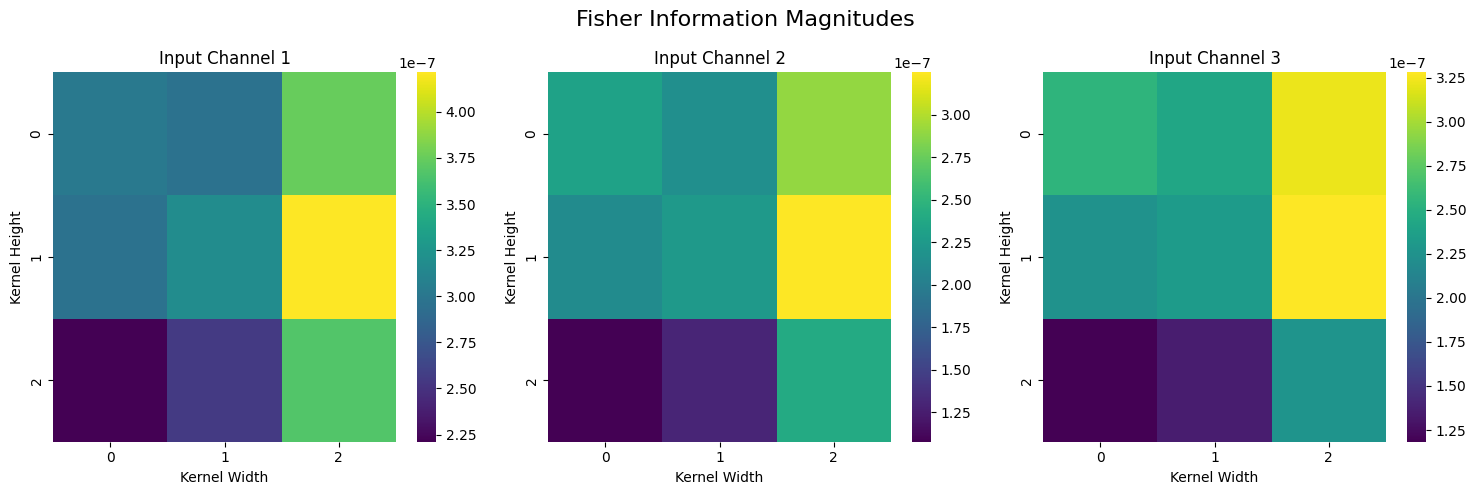

In [ ]:
fisher_kernel_0 = fisher_layer_0[:, :, :, 0]  

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):  # Input channels
    sns.heatmap(fisher_kernel_0[:, :, i], cmap='viridis', ax=axes[i], cbar=True)
    axes[i].set_title(f"Input Channel {i + 1}")
    axes[i].set_xlabel("Kernel Width")
    axes[i].set_ylabel("Kernel Height")
plt.suptitle("Fisher Information Magnitudes", fontsize=16)
plt.tight_layout()
plt.show()

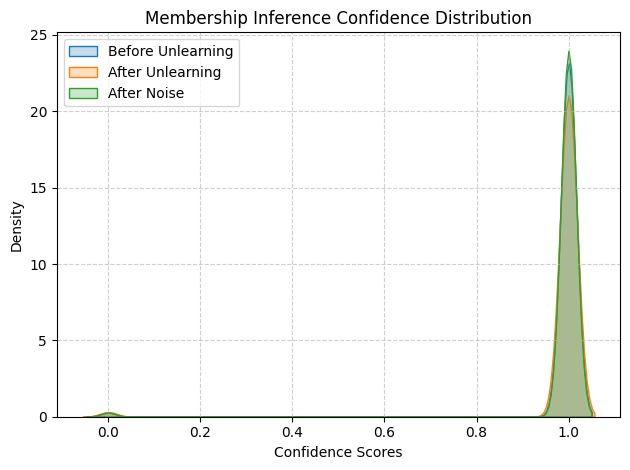

In [ ]:
sns.kdeplot(forget_confidences_before, label='Before Unlearning', fill=True)
sns.kdeplot(forget_confidences_after_unlearning, label='After Unlearning', fill=True)
sns.kdeplot(forget_confidences_after_noise, label='After Noise', fill=True)

plt.title("Membership Inference Confidence Distribution")
plt.xlabel("Confidence Scores")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

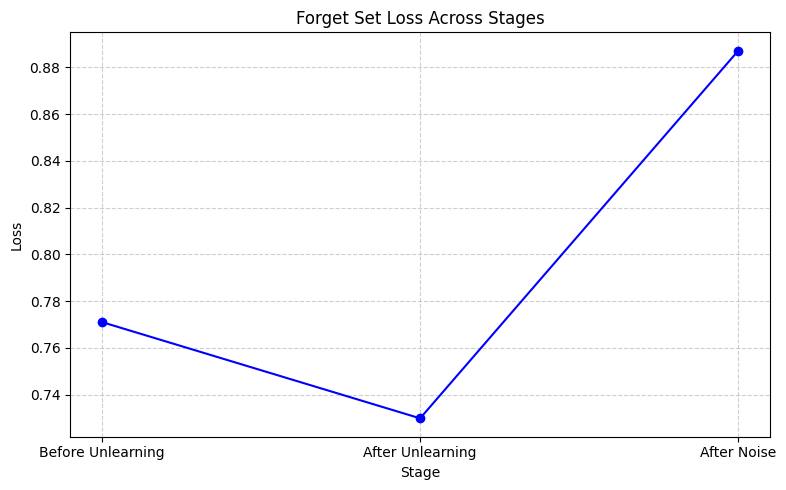

In [20]:
loss_values = [forget_loss_before, forget_loss_after_unlearning, forget_loss_after_noise]
stages = ['Before Unlearning', 'After Unlearning', 'After Noise']

plt.figure(figsize=(8, 5))
plt.plot(stages, loss_values, marker='o', color='blue')
plt.title("Forget Set Loss Across Stages")
plt.xlabel("Stage")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

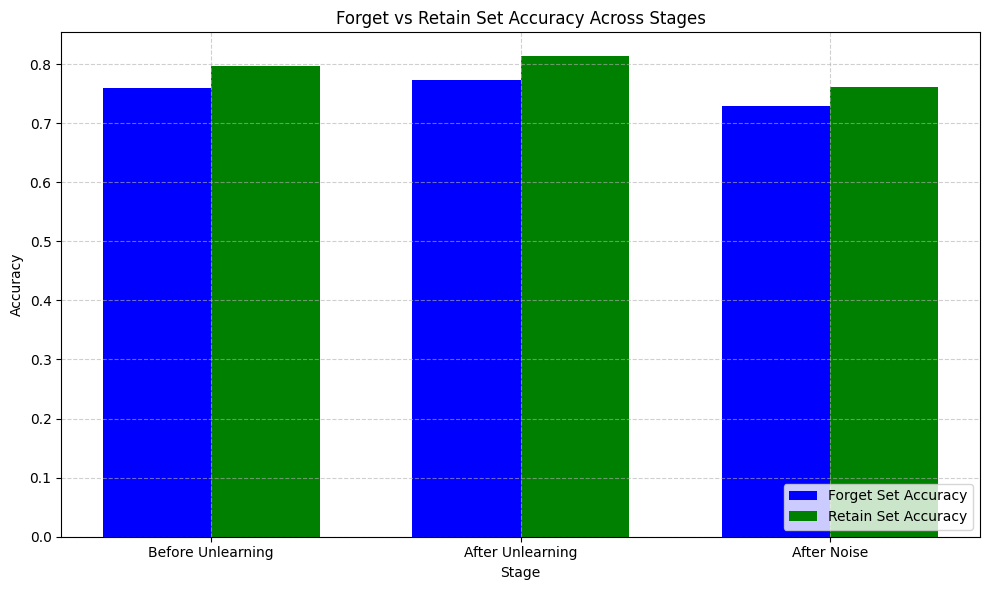

In [ ]:
forget_accuracies = [forget_accuracy_before, forget_accuracy_after_unlearning, forget_accuracy_after_noise]
retain_accuracies = [retain_accuracy_before, retain_accuracy_after_unlearning, retain_accuracy_after_noise]
stages = ['Before Unlearning', 'After Unlearning', 'After Noise']

x = np.arange(len(stages)) 
width = 0.35  

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, forget_accuracies, width, label='Forget Set Accuracy', color='blue')
plt.bar(x + width/2, retain_accuracies, width, label='Retain Set Accuracy', color='green')

plt.title("Forget vs Retain Set Accuracy Across Stages")
plt.xlabel("Stage")
plt.ylabel("Accuracy")
plt.xticks(x, stages)
plt.legend(loc='lower right') 
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Text(0, 0.5, 't-SNE Dimension')

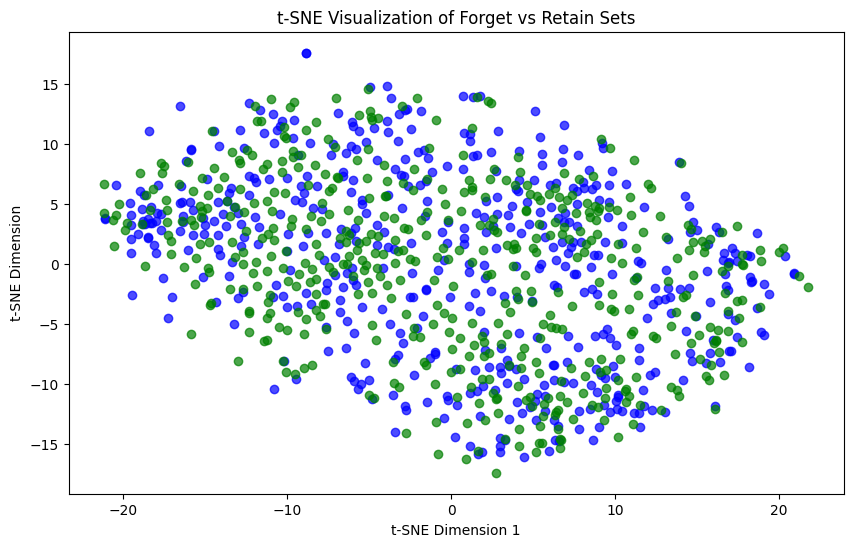

In [ ]:
from sklearn.manifold import TSNE

x_forget_flat = x_forget.reshape(len(x_forget), -1) / 255.0
x_retain_flat = x_retain.reshape(len(x_retain), -1) / 255.0

data = np.vstack((x_forget_flat[:500], x_retain_flat[:500]))  
labels = np.hstack((np.zeros(500), np.ones(500)))  

tsne = TSNE(n_components=2, random_state=42)
embeddings = tsne.fit_transform(data)

plt.figure(figsize=(10, 6))
plt.scatter(embeddings[labels == 0, 0], embeddings[labels == 0, 1], label='Forget Set', alpha=0.7, color='blue')
plt.scatter(embeddings[labels == 1, 0], embeddings[labels == 1, 1], label='Retain Set', alpha=0.7, color='green')

plt.title("t-SNE Visualization of Forget vs Retain Sets")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension")

In [24]:
results_df

,threshold,stddev,rate,factor,forget_loss_before,forget_accuracy_before,forget_loss_after_unlearning,forget_accuracy_after_unlearning,forget_loss_after_noise,forget_accuracy_after_noise,retain_loss_before,retain_accuracy_before,retain_loss_after_unlearning,retain_accuracy_after_unlearning,retain_loss_after_noise,retain_accuracy_after_noise
0,0.9,0.01,0.00001,0.0001,0.770995,0.7596,0.729822,0.7734,0.887096,0.7288,0.652092,0.797175,0.604696,0.813075,0.764876,0.7607
